### Install and Import

In [3]:
pip install tensorflow==2.11.0 opencv-python mediapipe scikit-learn matplotlib


  Using cached mediapipe-0.10.11-cp39-cp39-win_amd64.whl (50.8 MB)
  Using cached sounddevice-0.4.6-py3-none-win_amd64.whl (199 kB)
  Using cached opencv_contrib_python-4.9.0.80-cp37-abi3-win_amd64.whl (45.3 MB)
  Using cached jax-0.4.25-py3-none-any.whl (1.8 MB)
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\avani\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [1]:
import cv2
import numpy as np
import os
import time
from matplotlib import pyplot as plt
import mediapipe as mp
from datetime import datetime

### Drawing Keypoints on Video Feed

In [2]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [47]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
  while cap.isOpened(): #always

    ret, frame = cap.read()

    image, results = mediapipe_detection(frame, holistic)

    draw_styled_landmarks(image, results)

    cv2.imshow('OpenCV Feed', image)
    if cv2.waitKey(10) & 0xFF == ord('q'):
      break
  cap.release()
  cv2.destroyAllWindows()

In [6]:
len(results.face_landmarks.landmark)

NameError: name 'results' is not defined

In [7]:
draw_landmarks(frame, results)

NameError: name 'frame' is not defined

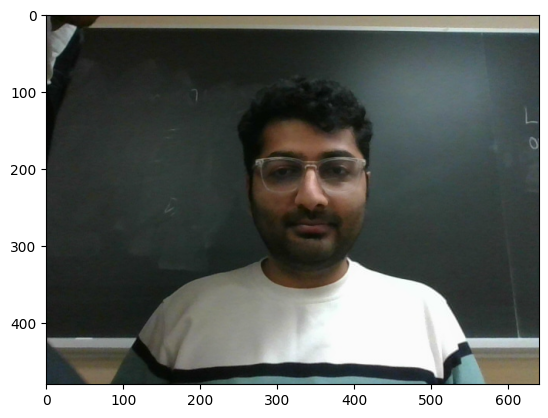

In [48]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

### Extracting Keypoints

In [9]:
len(results.pose_landmarks.landmark)

NameError: name 'results' is not defined

In [10]:
len(results.face_landmarks.landmark)

NameError: name 'results' is not defined

In [11]:
len(results.left_hand_landmarks.landmark)

NameError: name 'results' is not defined

In [12]:
len(results.right_hand_landmarks.landmark)

NameError: name 'results' is not defined

In [6]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [7]:
extract_keypoints(results)[:5]

NameError: name 'results' is not defined

### Folders for Image's NumPy Array Storage

In [8]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

In [45]:
for action in actions: 
    dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))
    # Folder start
    start_folder = dirmax
    print(dirmax)
    temp_strg=DATA_PATH+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    for sequence in range(1,no_sequences+1):
        try: 
            os.makedirs(os.path.join(temp_strg, action, str(dirmax+sequence)))
        except:
            pass

59
59
59


In [17]:
# for action in actions: 
#     for sequence in range(no_sequences):
#         try: 
#             os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
#         except:
#             pass

### Collecting Keypoints for Training

In [9]:
def make_npy_array(action):

    cap = cv2.VideoCapture(0)
    # Set mediapipe model 
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        
        # NEW LOOP
        # Loop through actions
        # for action in actions:
        # Loop through sequences aka videos
        for sequence in range(start_folder, start_folder+no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(temp_strg, action, str(sequence+1), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                        
        cap.release()
        cv2.destroyAllWindows()

In [10]:
# for hello
make_npy_array(actions[0])

NameError: name 'start_folder' is not defined

In [52]:
# for thanks
make_npy_array(actions[1])

In [53]:
# for iloveyou
make_npy_array(actions[2])

### Preprocessing and EDA

In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [12]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [13]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [14]:
np.array(sequences).shape

# (no_of_videos, no_of_frames_in_each_video, no_of_keypoints_in_each_frame)

(270, 30, 1662)

In [15]:
np.array(labels).shape

# (no_of_labels) same as number of videos

(270,)

In [16]:
X = np.array(sequences)

In [17]:
y = to_categorical(labels).astype(int)
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1,

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [19]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(216, 30, 1662) (54, 30, 1662) (216, 3) (54, 3)


### Building the CNN

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Dropout

In [54]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [55]:
model=Sequential()
model.add(Conv2D(128,kernel_size=(5,5),
                 strides=1,padding='same',activation='relu',input_shape=(30,1662,1)))
model.add(MaxPool2D(pool_size=(3,3),strides=2,padding='same'))
model.add(Conv2D(64,kernel_size=(2,2),
                strides=1,activation='relu',padding='same'))
model.add(MaxPool2D((2,2),2,padding='same'))
model.add(Conv2D(32,kernel_size=(2,2),
                strides=1,activation='relu',padding='same'))
model.add(MaxPool2D((2,2),2,padding='same'))
          
model.add(Flatten())


In [56]:
model.add(Dense(units=512,activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(actions.shape[0],activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 1662, 128)     3328      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 15, 831, 128)     0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 15, 831, 64)       32832     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 8, 416, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 8, 416, 32)        8224      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 4, 208, 32)      

In [57]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [58]:
model.fit(X_train, y_train, epochs=10, callbacks=[tb_callback])

Epoch 1/10
7/7 [==============================] - 53s 5s/step - loss: 1.3832 - categorical_accuracy: 0.3657
Epoch 2/10
7/7 [==============================] - 35s 5s/step - loss: 0.9856 - categorical_accuracy: 0.6481
Epoch 3/10
7/7 [==============================] - 35s 5s/step - loss: 0.6342 - categorical_accuracy: 0.7269
Epoch 4/10
7/7 [==============================] - 32s 5s/step - loss: 0.5052 - categorical_accuracy: 0.7963
Epoch 5/10
7/7 [==============================] - 34s 5s/step - loss: 0.4598 - categorical_accuracy: 0.7546
Epoch 6/10
7/7 [==============================] - 33s 5s/step - loss: 0.3275 - categorical_accuracy: 0.8750
Epoch 7/10
7/7 [==============================] - 33s 5s/step - loss: 0.2418 - categorical_accuracy: 0.9074
Epoch 8/10
7/7 [==============================] - 33s 5s/step - loss: 0.1621 - categorical_accuracy: 0.9491
Epoch 9/10
7/7 [==============================] - 40s 6s/step - loss: 0.1908 - categorical_accuracy: 0.9306
Epoch 10/10
7/7 [===========

In [59]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 1662, 128)     3328      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 15, 831, 128)     0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 15, 831, 64)       32832     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 8, 416, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 8, 416, 32)        8224      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 4, 208, 32)      

### Predictions

In [60]:
res = model.predict(X_test)
res

2/2 [==============================] - 3s 1s/step


array([[9.59902465e-01, 3.11601398e-05, 4.00663316e-02],
       [6.96493164e-02, 7.66720972e-04, 9.29583907e-01],
       [4.56974423e-03, 9.25529399e-04, 9.94504750e-01],
       [9.87103045e-01, 2.42171291e-06, 1.28944749e-02],
       [1.39678623e-05, 9.96129394e-01, 3.85653274e-03],
       [1.32966336e-04, 9.84474301e-01, 1.53927058e-02],
       [2.95915088e-05, 3.46254170e-01, 6.53716207e-01],
       [9.85924780e-01, 1.07889855e-05, 1.40644405e-02],
       [1.07313429e-06, 9.94616210e-01, 5.38278278e-03],
       [9.90257740e-01, 1.79478945e-06, 9.74050630e-03],
       [2.77164963e-06, 9.96270776e-01, 3.72642186e-03],
       [4.77798432e-02, 5.85931237e-04, 9.51634228e-01],
       [6.28880109e-04, 6.02349523e-04, 9.98768747e-01],
       [3.01908676e-05, 9.78559315e-01, 2.14104112e-02],
       [2.47014104e-04, 9.85708833e-01, 1.40441321e-02],
       [6.82135522e-02, 8.74894613e-05, 9.31699038e-01],
       [9.28160012e-01, 2.83640547e-05, 7.18116164e-02],
       [2.06488848e-01, 4.47494

### Saving Weights

In [61]:
# model.save('modelWeight.h5')

### Evaluation

In [62]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [63]:
yhat = model.predict(X_test)

2/2 [==============================] - 2s 732ms/step


In [64]:
ytrue = np.argmax(y_test, axis=1).tolist()
ytrue

[0,
 2,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 0,
 1,
 2,
 2,
 1,
 1,
 2,
 0,
 2,
 1,
 0,
 2,
 2,
 2,
 2,
 1,
 0,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 1,
 0,
 0,
 1,
 0,
 2,
 2]

In [65]:
yhat = np.argmax(yhat, axis=1).tolist()
yhat

[0,
 2,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 0,
 1,
 2,
 2,
 1,
 1,
 2,
 0,
 2,
 1,
 0,
 2,
 2,
 2,
 0,
 1,
 0,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 1,
 0,
 0,
 1,
 0,
 2,
 2]

In [66]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[37,  1],
        [ 0, 16]],

       [[36,  0],
        [ 0, 18]],

       [[34,  0],
        [ 1, 19]]], dtype=int64)

In [67]:
accuracy_score(ytrue, yhat)

0.9814814814814815

### Real-Time

In [82]:
from scipy import stats

In [83]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [84]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

TypeError: only length-1 arrays can be converted to Python scalars

<Figure size 1800x1800 with 0 Axes>

In [85]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        # print(results)
        
        # Draw landmarks
        # draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('SignLearn', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

1/1 [==============================] - 0s 191ms/step
hello
1/1 [==============================] - 0s 32ms/step
hello
1/1 [==============================] - 0s 34ms/step
hello
1/1 [==============================] - 0s 33ms/step
hello
1/1 [==============================] - 0s 51ms/step
hello
1/1 [==============================] - 0s 34ms/step
hello
1/1 [==============================] - 0s 35ms/step
hello
1/1 [==============================] - 0s 29ms/step
hello
1/1 [==============================] - 0s 35ms/step
hello
1/1 [==============================] - 0s 34ms/step
hello
1/1 [==============================] - 0s 34ms/step
hello
1/1 [==============================] - 0s 35ms/step
hello
1/1 [==============================] - 0s 33ms/step
hello
1/1 [==============================] - 0s 37ms/step
hello
1/1 [==============================] - 0s 35ms/step
hello
1/1 [==============================] - 0s 35ms/step
hello
1/1 [==============================] - 0s 29ms/step
hello
1/1 [========